In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [37]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Examine tables 


In [10]:
# Initiate an 'inspector' object for gaining information about our tables more easily
inspector = inspect(engine)

# Print columns with types of measurement table
measurement_columns = inspector.get_columns("measurement")
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Print out first 5 rows of measurement table for inspection
for row in session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
        limit(5).all():
    print(row)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)


In [12]:
# Print columns with types of station table
station_columns = inspector.get_columns("station")
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Print out first 5 rows of station table for inspection
for row in session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
        all():
    print(row)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


## Precipitation analysis

### Design a query to retrieve the last 12 months of precipitation data


In [14]:
# Pull the last date as the end date from the measurement table and convert it to a datetime object
end_date = session.query(Measurement.date).\
        order_by(Measurement.date.desc()).first()[0]
end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')

# Define the date one year prior as the start date
start_date = dt.datetime(end_date.year - 1, end_date.month, end_date.day)

# Query for the last 12 months of precipitation data and save it into a dataframe, set index to date column
results = session.query(Measurement.date, Measurement.prcp).\
                filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).\
                order_by(Measurement.date).all()

prcp_df = pd.DataFrame(results, columns=['date', 'precipitation']).set_index('date')

### Plot the data and print summary statistics

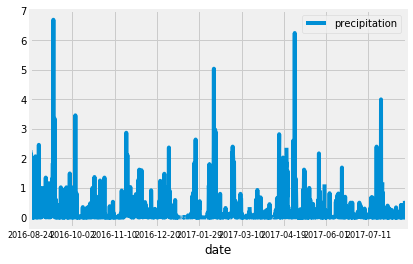

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.xticks(fontsize=8)
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station analysis

### Basic queries

In [17]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Station.station)).distinct().all()[0][0]
num_stations

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Station.station, func.count(Measurement.id)).\
                join(Measurement, Station.station == Measurement.station).\
                group_by(Station.station).order_by(func.count(Measurement.id).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Find the most active station
most_active_station = station_activity[0][0]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?
low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).all()[0][0]
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).all()[0][0]
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()[0][0]

print(f"Lowest recorded temperature at station {most_active_station}: {low_temp}\n"
      f"Highest recorded temperature at station {most_active_station}: {high_temp}\n"
      f"Average recorded temperature at station {most_active_station}: {avg_temp}")

Lowest recorded temperature at station USC00519281: 54.0
Highest recorded temperature at station USC00519281: 85.0
Average recorded temperature at station USC00519281: 71.66378066378067


### Queries and plotting

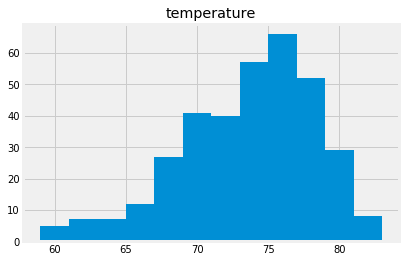

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query
results = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).\
                order_by(Measurement.date).all()

# Define dataframe and drop 'station' column since value is same for all rows
station_df = pd.DataFrame(results, columns = ['station', 'date', 'temperature'])
station_df = station_df[['date', 'temperature']]

# Plot histogram
station_df.hist(column='temperature', bins=12)
plt.show()

## My trip analysis

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = dt.date(2019, 8, 2)
trip_end = dt.date(2019, 8, 10)

start_date = dt.datetime(trip_start.year - 2, trip_start.month, trip_start.day)
end_date = dt.datetime(trip_end.year - 2, trip_end.month, trip_end.day)

calc_temps(start_date, end_date)

[(71.0, 79.61290322580645, 83.0)]

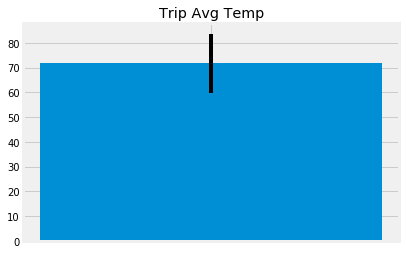

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = calc_temps(start_date, end_date)[0][0]
tavg = calc_temps(start_date, end_date)[0][1]
tmax = calc_temps(start_date, end_date)[0][2]

plt.bar(x='', height=avg_temp, yerr=tmax-tmin)
plt.title('Trip Avg Temp')
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
            join(Measurement, Station.station == Measurement.station).\
            filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).\
            group_by(Measurement.station).order_by().all()

[('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.15000000000000002),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.6699999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

# Optional Challenge Assignment

In [60]:
# Create a query that will calculate the daily normals 
# (i.e. tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()[0]
    
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [61]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to save a list of %m-%d strings after stripping the year
date_range = (end_date - start_date).days
date_list = []

for date in (start_date + timedelta(n) for n in range(date_range + 1)):
    date = dt.datetime.strftime(date, "%m-%d")
    date_list.append(date)

date_list

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date) for date in date_list]
normals

[(68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0),
 (68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0)]

In [62]:
# Load the previous query results into a Pandas DataFrame and add the `date_list` range as the `date` index
df = pd.DataFrame(normals, index=date_list, columns=['tmin', 'tavg', 'tmax'])
df

,tmin,tavg,tmax
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0
08-08,68.0,76.557692,83.0
08-09,69.0,75.980392,81.0
08-10,65.0,76.420000,83.0


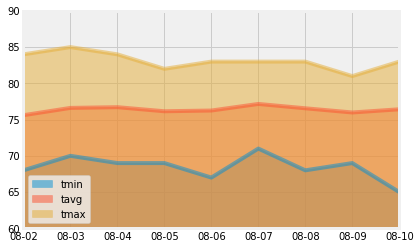

In [65]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)
plt.ylim(top=90, bottom=60)
plt.show()